In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [24]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from matplotlib import rc; rc('text', usetex=True)

## 1) Generate a trajectory
We generate a test trajectory of the SIR class on a population with two ages groups.

In [25]:
M = 2                # the population has two age groups
N = 5e4              # and this is the total population

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])


def contactMatrix(t):   
    return C

# duration of simulation and data file
Tf = 100;  
Nt=Tf+1; 

I0 = np.array([10, 10])  # each age group has asymptomatic infectives
R0  = np.array([10, 10])    # there are no recovered individuals initially
S0  = Ni - (I0 + R0)

x0 = np.concatenate((S0, I0))/N

beta = 0.02
alpha = 0.2
gIa = 1/7 
gIs = 1/7 
fsa = 1


# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])  # and also symptomatic infectives
R0  = np.array([0, 0])    # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
true_parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']

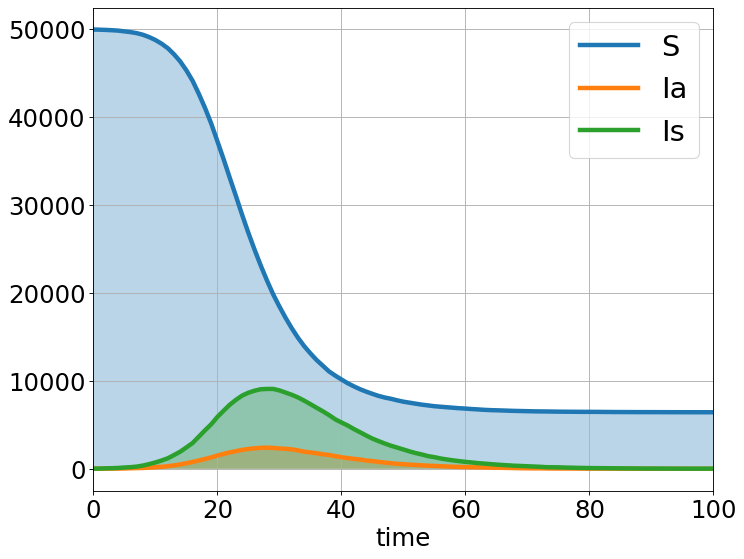

In [26]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
t = data['t']

plt.fill_between(t, 0, np.sum(data_array[:, :M], axis=1),  alpha=0.3)
plt.plot(t, np.sum(data_array[:, :M], axis=1), '-', label='S', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, M:2*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-', label='Ia', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, 2*M:3*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-', label='Is', lw=4)

plt.legend(fontsize=26)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

In [14]:
# load the data and rescale to intensive variables 
Tf_inference = 20 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1
steps = 101 # number internal integration steps taken, must be an odd number 

x = (data_array[:Nf_inference]).astype('float')/N 

### 2) Make the Spp class using model_spec

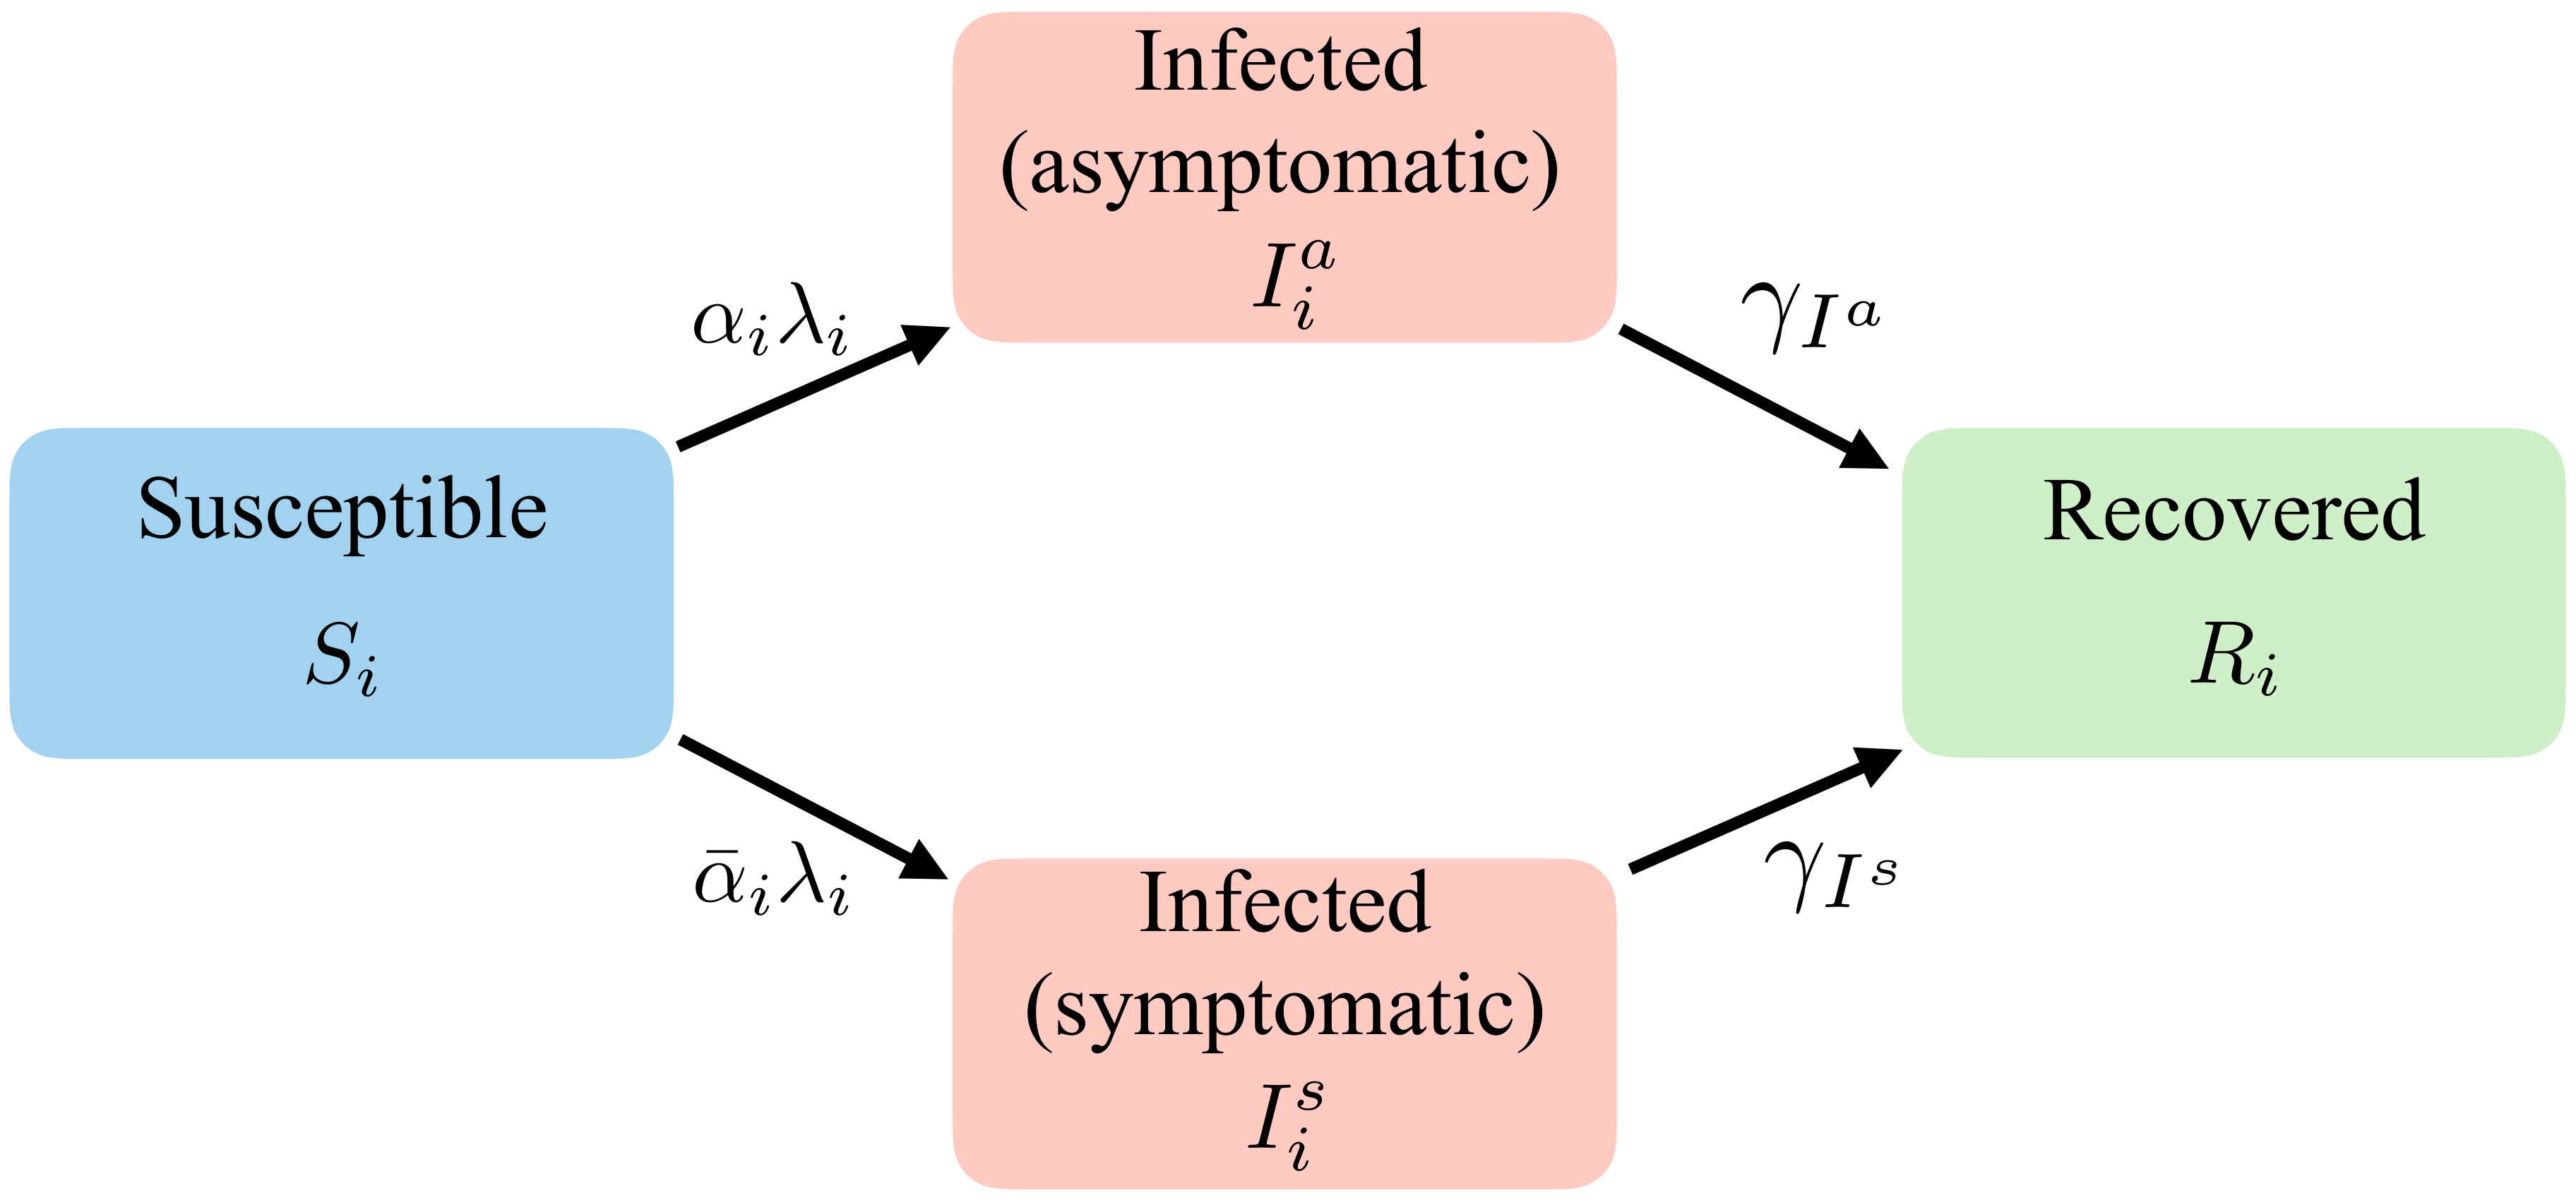

In [27]:
from IPython.display import Image
Image('SIIR.jpg')

In [15]:
inference_parameters = {
    'betaIa' : beta*alpha, 
    'betaIs' : beta*(1-alpha), 
    'gIa' : gIa, 
    'gIs' : gIs
}

model_spec = {
    "classes" : ["S", "Ia", "Is"],

    "S" : {
        "linear"    : [],
        "infection" : [ ["Ia", "-betaIa"], ["Is", "-betaIa"], ["Ia", "-betaIs"], ["Is", "-betaIs"]]
    },
    "Ia" : {
        "linear"    : [ ["Ia", "-gIa"] ],
        "infection" : [ ["Ia", "betaIa"], ["Is", "betaIa"] ]
    }, 
    "Is" :{
        "linear"    : [ ["Is", "-gIs"] ],
        "infection" : [ ["Is", "betaIs"], ["Ia", "betaIs"]]
    }
}

# initialise the estimator 
estimator = pyross.inference.Spp(model_spec, inference_parameters, M, fi, int(N), steps)

# check integrate 
logp = estimator.obtain_minus_log_p(inference_parameters, x, Tf_inference, Nf_inference, contactMatrix)
print(logp)

-893.8804608247231


In [16]:
# Define the prior (Gamma prior around guess of parameter with defined std. deviation)
betaIs_g = 0.04
betaIs_std = 0.04

betaIa_g = 0.005
betaIa_std = 0.01 

gIa_g = 0.1
gIa_std = 0.1

gIs_g = 0.1
gIs_std = 0.1

# compute -log_p for the initial guess 
guessed_parameters = {
    'betaIa' : betaIa_g, 
    'betaIs' : betaIs_g, 
    'gIa' : gIa_g, 
    'gIs' : gIs_g
}

logp = estimator.obtain_minus_log_p(guessed_parameters, x, Tf_inference, Nf_inference, contactMatrix)
print(logp) 

2362.151765661384


In [17]:
## inference 
ftol = 1e-4  # Stopping criterion for minimisation (realtive change in function value)
keys = ['betaIa', 'betaIs', 'gIa', 'gIs']
guess = np.array([betaIa_g, betaIs_g, gIa_g, gIs_g])  # Initial value (and expected value of priors)
stds = np.array([betaIa_std, betaIs_std , gIa_std, gIs_std])

eps = 1e-4 
bounds = np.array([(eps, 0.5), (eps, 0.5), (eps, 0.6), (eps, 0.6)])  # give some bounds 
params = estimator.infer_parameters(keys, guess, stds, bounds, x, Tf_inference, Nf_inference, contactMatrix, 
                                    global_max_iter=20, local_max_iter=200, 
                                    global_ftol_factor=1e3, ftol=ftol, verbose=True)

print(params) # best guess 

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 4 (seed=3839882179, Thu May 14 20:48:40 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -6.521410401497692e+02 1.0e+00 1.02e+00  1e-02  1e-01 0:03.0
    2     32 -8.356990354885938e+02 1.3e+00 8.34e-01  8e-03  9e-02 0:05.3
    3     48 -6.477193501494181e+02 1.7e+00 7.49e-01  7e-03  9e-02 0:07.6
    5     80 -5.878363639581971e+02 3.9e+00 7.19e-01  8e-03  9e-02 0:12.5
    7    112 -8.400157990071325e+02 5.9e+00 5.62e-01  5e-03  7e-02 0:17.0
   10    160 -8.478344971434688e+02 1.4e+01 6.73e-01  5e-03  1e-01 0:23.3
   13    208 -8.874318933514908e+02 2.0e+01 6.04e-01  4e-03  1e-01 0:30.0
Optimal value (global minimisation):  -898.2577826994087
Starting local minimisation...
Optimal value (local minimisation):  -903.1152364500376
[0.00468651 0.01507609 0.21709136 0.12713143]


In [18]:
print("True parameters:")
print(inference_parameters)

print("\nInferred parameters:")
best_estimates = estimator.fill_params_dict(keys, params)
print(best_estimates)

True parameters:
{'betaIa': 0.004, 'betaIs': 0.016, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285}

Inferred parameters:
{'betaIa': 0.004686507041426538, 'betaIs': 0.015076090571049139, 'gIa': 0.21709135592552578, 'gIs': 0.1271314305305477}


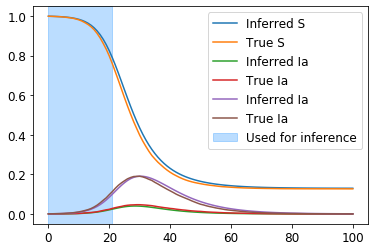

In [21]:
Nf = 101
Tf = Nf-1

model = pyross.deterministic.Spp(model_spec, best_estimates, int(M), fi)
det_data = model.simulate(x[0], contactMatrix, Tf, Nf)
x_det = det_data['X']
x = data['X']/N
plt.rcParams.update({'font.size': 12})
plt.plot(np.sum(x_det[:, :M], axis=1), label='Inferred S')
plt.plot(np.sum(x[:, :M], axis=1), label='True S')
plt.plot(np.sum(x_det[:, M:2*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:, M:2*M], axis=1), label='True Ia')
plt.plot(np.sum(x_det[:, 2*M:3*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:, 2*M:3*M], axis=1), label='True Ia')
plt.axvspan(0, Nf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.legend()
plt.show() 